In [1]:
import ccxt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from scipy.stats import skew, kurtosis

In [2]:
def fetch_bybit_data(symbol='BTC/USDT', timeframe='5m', limit=1000):
    exchange = ccxt.bybit({
        'options': {'defaultType': 'linear'}  # Required for USDT Perpetuals
    })
    exchange.load_markets()
    
    data = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit, params = {"paginate": True})
    df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df

In [3]:
#df = fetch_bybit_data(timeframe='5m', limit=20000)
df = pd.read_csv('data/btcusdt_5min.csv')

In [4]:
df.head()

,timestamp,open,high,low,close,volume
0,2025-03-31 12:35:00,82199.5,82249.9,82113.6,82186.9,11.545725
1,2025-03-31 12:40:00,82186.9,82528.0,82146.0,82490.9,54.304581
2,2025-03-31 12:45:00,82490.9,82490.9,82390.0,82472.6,54.241944
3,2025-03-31 12:50:00,82472.6,83155.8,82472.6,82864.3,210.304118
4,2025-03-31 12:55:00,82864.3,82911.7,82760.1,82779.0,59.860116


In [5]:
#df.to_csv('data/btcusdt_5min.csv')

In [6]:
# Prepare a list to store results
window = 24
threshold = 0.03
pnl_results = []

# Try all possible 2-hour windows starting from shift 0 to shift 23
for offset in range(window):
    df['label'] = np.nan

    # Step through the data starting from the offset, in non-overlapping chunks
    for start in range(offset, len(df) - window, window):
        end = start + window
        start_price = df['close'].iloc[start]
        end_price = df['close'].iloc[end]
        slope = (end_price - start_price) / window

        if slope > threshold:
            df.iloc[start, df.columns.get_loc('label')] = 1
        elif slope < -threshold:
            df.iloc[start, df.columns.get_loc('label')] = -1

    # Filter to only labeled points and de-duplicate consecutive ones
    labeled = df[df['label'].notna()].copy()
    labeled['prev_label'] = labeled['label'].shift(1)
    labeled_filtered = labeled[labeled['label'] != labeled['prev_label']].copy()

    # Compute log returns
    labeled_filtered['log_return'] = np.log(labeled_filtered.close/labeled_filtered.close.shift(1))

    # Compute realized PnL
    labeled_filtered['realized_pnl'] = labeled_filtered['label'].shift(1) * labeled_filtered['log_return']

    # Sum up total PnL
    total_pnl = labeled_filtered['realized_pnl'].sum()
    pnl_results.append((offset, total_pnl))

# Convert results to DataFrame
pnl_df = pd.DataFrame(pnl_results, columns=['offset', 'total_realized_pnl'])

In [7]:
labeled_filtered

,timestamp,open,high,low,close,volume,label,prev_label,log_return,realized_pnl
23,2025-03-31 14:30:00,82824.0,83474.1,82824.0,83443.8,63.686099,1.0,NaN,NaN,NaN
47,2025-03-31 16:30:00,83610.1,83610.1,83408.3,83536.3,17.169070,-1.0,1.0,0.001108,0.001108
119,2025-03-31 22:30:00,82346.1,82392.3,82314.4,82357.6,9.541882,1.0,-1.0,-0.014211,0.014211
191,2025-04-01 04:30:00,83057.0,83168.2,83057.0,83168.1,7.254342,-1.0,1.0,0.009793,0.009793
215,2025-04-01 06:30:00,83129.5,83177.2,83116.2,83162.3,10.778147,1.0,-1.0,-0.000070,0.000070
...,...,...,...,...,...,...,...,...,...,...
9791,2025-05-04 13:15:00,95452.3,95452.3,95348.9,95351.2,19.320785,1.0,-1.0,-0.006708,0.006708
9815,2025-05-04 15:15:00,95653.2,95653.2,95567.9,95620.1,14.018619,-1.0,1.0,0.002816,0.002816
9839,2025-05-04 17:15:00,95451.0,95451.1,95377.9,95381.0,12.478331,1.0,-1.0,-0.002504,0.002504
9887,2025-05-04 21:15:00,95623.4,95659.4,95623.3,95659.4,3.991697,-1.0,1.0,0.002915,0.002915


In [8]:
pnl_df

,offset,total_realized_pnl
0,0,1.957238
1,1,1.947857
2,2,1.986208
3,3,1.972201
4,4,2.011940
5,5,1.974548
6,6,1.993971
7,7,1.938174
8,8,2.032803
9,9,1.999165


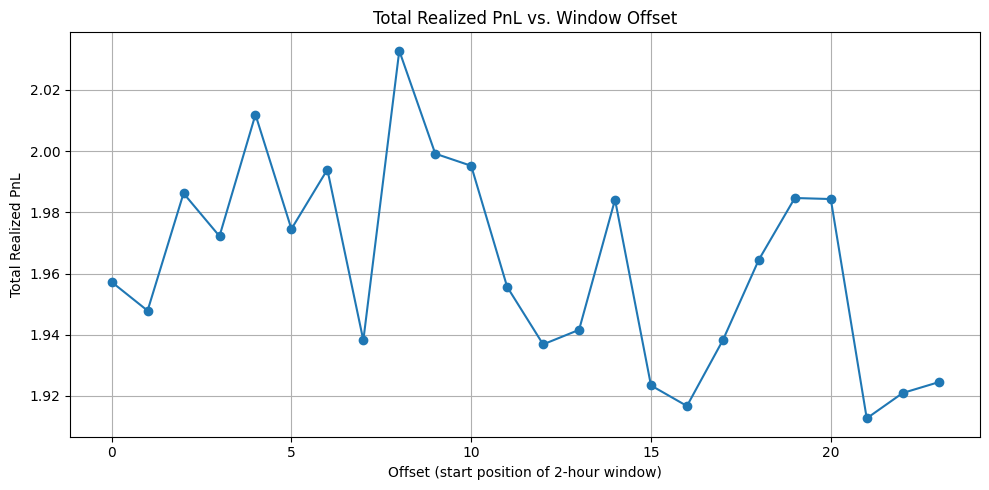

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(pnl_df['total_realized_pnl'], marker='o')
plt.title("Total Realized PnL vs. Window Offset")
plt.xlabel("Offset (start position of 2-hour window)")
plt.ylabel("Total Realized PnL")
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
def generate_labeled_trades(df_input, offset=0, window=24, threshold=0.03):
    """
    Generate trade labels and returns based on price trends over fixed windows.

    Parameters:
        df_input (pd.DataFrame): Must include a 'close' column with a datetime index.
        offset (int): Offset for the first labeling window (default 0).
        window (int): Number of rows in each analysis window.
        threshold (float): Minimum trend slope required to assign a label.

    Returns:
        pd.DataFrame: Original DataFrame with added columns:
                      'label_filtered', 'log_return', 'realized_pnl'.
    """
    df = df_input.copy()
    df['label'] = np.nan

    # Label trend windows
    for start in range(offset, len(df) - window, window):
        end = start + window
        start_price = df['close'].iloc[start]
        end_price = df['close'].iloc[end]
        slope = (end_price - start_price) / window

        if slope > threshold:
            df.iloc[start, df.columns.get_loc('label')] = 1
        elif slope < -threshold:
            df.iloc[start, df.columns.get_loc('label')] = -1

    # Filter changes in direction
    labeled = df[df['label'].notna()].copy()
    labeled['prev_label'] = labeled['label'].shift(1)
    labeled_filtered = labeled[labeled['label'] != labeled['prev_label']]

    # Compute returns
    labeled_filtered.loc[:, 'log_return'] = np.log(labeled_filtered['close'] / labeled_filtered['close'].shift(1))
    labeled_filtered.loc[:, 'realized_pnl'] = labeled_filtered['log_return'] * labeled_filtered['label'].shift(1)
    labeled_filtered.loc[:,'label_filtered'] = labeled_filtered['label']

    # Update the original DataFrame
    df[['label_filtered', 'log_return', 'realized_pnl']] = np.nan  # Ensure columns exist
    df.update(labeled_filtered[['label_filtered', 'log_return', 'realized_pnl']])

    return df

In [16]:
df = generate_labeled_trades(df, offset=8, window=24, threshold=0.03)

In [17]:
df.head()

,timestamp,open,high,low,close,volume,label,label_filtered,log_return,realized_pnl
0,2025-03-31 12:35:00,82199.5,82249.9,82113.6,82186.9,11.545725,NaN,NaN,NaN,NaN
1,2025-03-31 12:40:00,82186.9,82528.0,82146.0,82490.9,54.304581,NaN,NaN,NaN,NaN
2,2025-03-31 12:45:00,82490.9,82490.9,82390.0,82472.6,54.241944,NaN,NaN,NaN,NaN
3,2025-03-31 12:50:00,82472.6,83155.8,82472.6,82864.3,210.304118,NaN,NaN,NaN,NaN
4,2025-03-31 12:55:00,82864.3,82911.7,82760.1,82779.0,59.860116,NaN,NaN,NaN,NaN


In [18]:
df.label_filtered.value_counts()

label_filtered
 1.0    101
-1.0    100
Name: count, dtype: int64

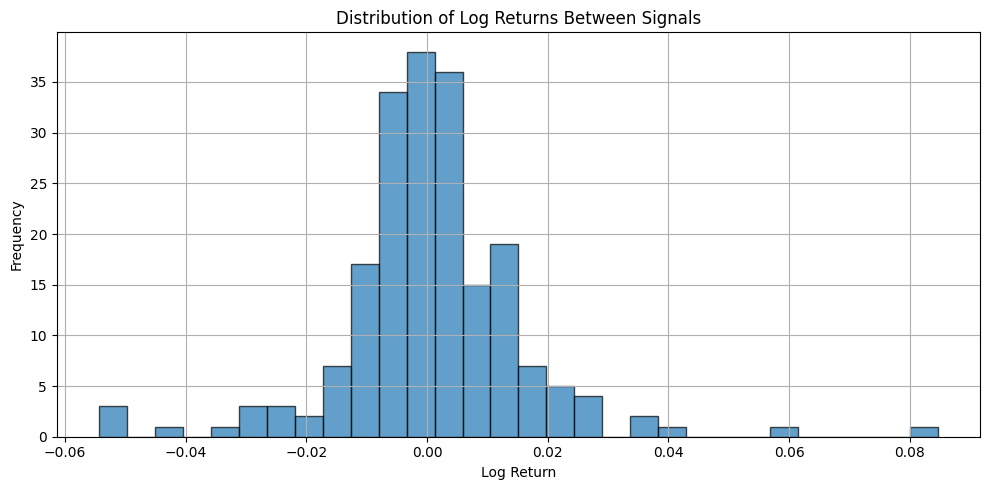

In [19]:
returns = df['log_return'].dropna()
# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(returns, bins=30, edgecolor='black', alpha=0.7)
plt.title("Distribution of Log Returns Between Signals")
plt.xlabel("Log Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
# Extract labeled entries for plotting
up = df[df['label_filtered'] == 1]
down = df[df['label_filtered'] == -1]

# Plot interactively
fig = go.Figure()

# Price line
fig.add_trace(go.Scatter(
    x=df.index, y=df['close'],
    mode='lines', name='Close Price', line=dict(color='black')
))

# Uptrend markers
fig.add_trace(go.Scatter(
    x=up.index, y=up['close'],
    mode='markers', name='Uptrend Entry',
    marker=dict(symbol='triangle-up', size=10, color='green')
))

# Downtrend markers
fig.add_trace(go.Scatter(
    x=down.index, y=down['close'],
    mode='markers', name='Downtrend Entry',
    marker=dict(symbol='triangle-down', size=10, color='red')
))

fig.update_layout(
    title="Non-Overlapping 2-Hour Slope-Based Labels",
    xaxis_title="Time",
    yaxis_title="Price",
    height=600,
    legend=dict(x=0, y=1)
)

fig.show()